![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)

# Adaptive Uniform Grid
The goal of this project is to compare and evaluate grid methods used for numerical integration in quantum chemistry and to demonstrate the construction of `AdaptiveUniformGrid`.

## Environment Setup

In [7]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from collections import deque
from typing import Callable, Optional
sys.path.insert(0, os.path.abspath('../src'))
sys.path.insert(0, os.path.abspath('../src/grid/tests'))
from grid.basegrid import Grid
from grid.cubic import UniformGrid, AdaptiveUniformGrid
from test_CubicProTransform import (setup_environment, System, run_uniform_grid_method,run_transform_grid_method, test_grid_sizes, load_molecular_data)
deps = setup_environment()
deps['AdaptiveUniformGrid'] = AdaptiveUniformGrid

h2o_fchk_file = 'h2o.fchk'
h2_fchk_file = 'H2.fchk' 
h2o_system = System(h2o_fchk_file, deps)
h2_system = System(h2_fchk_file, deps)
bfit_data_file = 'result_kl_fpi_stype_only.npz'

All dependencies loaded successfully


### Part 1: Tests for `CubicProTransform`

#### 1. `UniformGrid` vs. `CubicProTransform` electron density integration H₂O

Compare the performance of `UniformGrid` against the `CubicProTransform` grid on a water molecule. We will evaluate the following metrics:

* **Integrated Electrons**: The result should be close to the total number of electrons in water (10).
* **Relative Error**: A measure of the integration accuracy.
* **Total Time**: The combined time for grid generation and integration.
* **Number of Grid Points**: A measure of computational cost.

In [8]:
if h2o_system and bfit_data_file and deps:
    uniform_result, _ = run_uniform_grid_method(h2o_system, deps)
    transform_result, _ = run_transform_grid_method(h2o_system, bfit_data_file, deps, grid_size=20)
    results_data = [
        {
            "Grid Method": "UniformGrid",
            "Integrated Electrons": uniform_result['electrons'],
            "Relative Error (%)": uniform_result['rel_error'] * 100,
            "Total Time (s)": uniform_result['time'],
            "Grid Points": uniform_result['points']
        },
        {
            "Grid Method": "CubicProTransform",
            "Integrated Electrons": transform_result['electrons'],
            "Relative Error (%)": transform_result['rel_error'] * 100,
            "Total Time (s)": transform_result['time'],
            "Grid Points": transform_result['points']
        }
    ]

    df_comparison = pd.DataFrame(results_data)
    display(df_comparison.style.format({
        'Integrated Electrons': '{:.6f}',
        'Relative Error (%)': '{:.6f}',
        'Total Time (s)': '{:.4f}',
        'Grid Points': '{:,}'
    }).set_caption("Integration Performance Comparison for Water Molecule"))

,Grid Method,Integrated Electrons,Relative Error (%),Total Time (s),Grid Points
0,UniformGrid,9.364999,6.350007,1.1040,"185,640"
1,CubicProTransform,10.017503,0.175034,5.5321,"8,000"


### 2. CubicProTransform performance changes with differs of grid sizes

In [9]:
if h2o_system and bfit_data_file and deps:
    grid_size_results = test_grid_sizes(h2o_system, bfit_data_file, deps)
    gs_data = []
    for size, result in grid_size_results.items():
        gs_data.append({
            "Grid Size": f"{size}<sup>3",
            "Grid Points": result['points'],
            "Integrated Electrons": result['electrons'],
            "Relative Error (%)": result['rel_error'] * 100,
            "Total Time (s)": result['time']
        })

    df_grid_size = pd.DataFrame(gs_data)
    display(df_grid_size.style.format({
        'Integrated Electrons': '{:.6f}',
        'Relative Error (%)': '{:.6f}',
        'Total Time (s)': '{:.4f}',
        'Grid Points': '{:,}'
    }).set_caption("Performance of CubicProTransform of different Grid Size (Water Molecule)"))

,Grid Size,Grid Points,Integrated Electrons,Relative Error (%),Total Time (s)
0,83,512,10.160400,1.604000,0.5486
1,103,"1,000",10.087279,0.872786,0.7807
2,123,"1,728",10.060062,0.600623,1.3595
3,153,"3,375",10.032942,0.329416,2.5912
4,183,"5,832",10.021731,0.217314,4.1041
5,203,"8,000",10.017503,0.175034,5.7487
6,253,"15,625",10.011348,0.113483,11.0458


## Part 2: Construct `AdaptiveUniformGrid`

While CubicProTransform is very efficient, its accuracy is indirectly controlled by `grid_size`. To provide a solution with direct control over accuracy, I try to implemented a dynamic adaptive uniform grid.

Core Algorithm:
1. Start: Start with a very coarse UniformGrid.
2. Evaluate: Evaluate the integral error at each grid cell.
3. Decide: If the error of a cell exceeds a user-defined threshold, tolerance , it is marked as "refinement."
4. Refine: Split the marked cell into smaller subcells and add them to a queue for processing.
5. Loop: Repeat steps 2-4 until the queue is empty, meaning all cells meet the required accuracy.

#### 1. Algorithm Visualization: Intelligent Refinement on a 2D Gaussian Function.

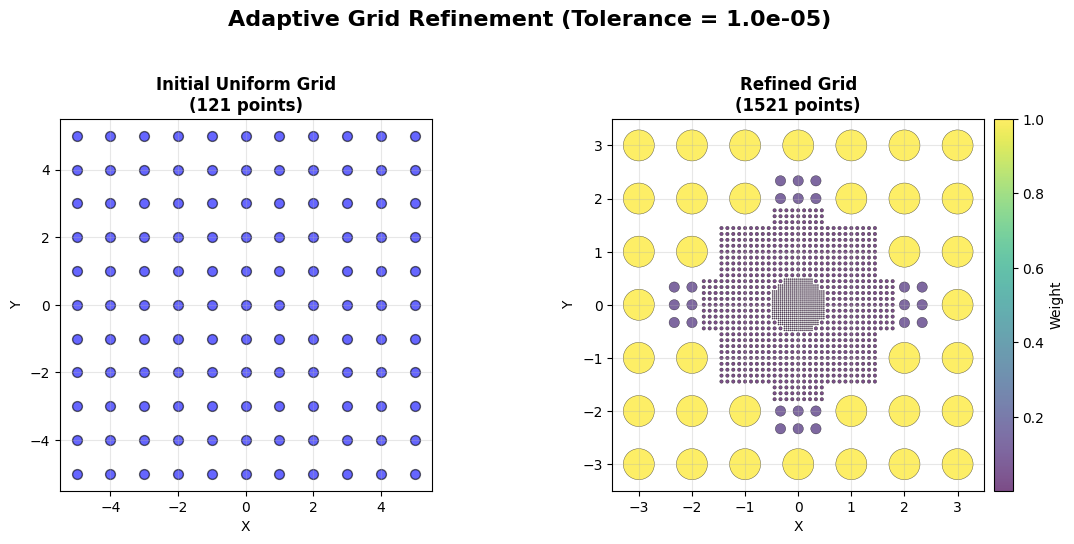

In [10]:
class AdaptiveGridVisualizer:
    def run_refinement(self, uniform_grid, func, tolerance, max_depth=10):
        adaptive = AdaptiveUniformGrid(uniform_grid, error_estimate="quadrature")
        result = adaptive.refinement(
            func=func, tolerance=tolerance, max_depth=max_depth
        )
        return result
    def visualize_before_after(self, uniform_grid, func, tolerance, zoom_box=None, max_depth=10):
        result = self.run_refinement(uniform_grid, func, tolerance, max_depth=max_depth)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5.5), facecolor='white')
        
        initial_points = uniform_grid.points
        ax1.scatter(initial_points[:, 0], initial_points[:, 1], s=50, c='blue', alpha=0.6, edgecolors='black')
        ax1.set_title(f'Initial Uniform Grid\n({len(initial_points)} points)', fontweight='bold')
        ax1.set_aspect('equal'); ax1.grid(True, alpha=0.3)
        ax1.set_xlabel('X'); ax1.set_ylabel('Y')
       
        final_points = result['final_grid'].points
        final_weights = result['final_grid'].weights
        sizes = 500 * final_weights / final_weights.max() if final_weights.max() > 0 else 50
        scatter = ax2.scatter(final_points[:, 0], final_points[:, 1], s=sizes, c=final_weights, 
                              cmap='viridis', alpha=0.7, edgecolors='black', linewidth=0.3)
        ax2.set_title(f'Refined Grid\n({len(final_points)} points)', fontweight='bold')
        ax2.set_aspect('equal'); ax2.grid(True, alpha=0.3)
        ax2.set_xlabel('X'); ax2.set_ylabel('Y')
        if zoom_box:
            ax2.set_xlim(zoom_box[0]); ax2.set_ylim(zoom_box[1])
        
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(scatter, cax=cax, label='Weight')
        
        fig.suptitle(f'Adaptive Grid Refinement (Tolerance = {tolerance:.1e})', fontsize=16, fontweight='bold')
        fig.tight_layout(rect=[0, 0, 1, 0.95])
        return fig
def gaussian_2d_moderate(points):
    return np.exp(-2 * np.sum(points**2, axis=1))
initial_grid_2d = UniformGrid(
    origin=np.array([-5.0, -5.0]),
    axes=np.diag([1.0, 1.0]),
    shape=np.array([11, 11]),
    weight="Rectangle"
)
visualizer = AdaptiveGridVisualizer()
fig = visualizer.visualize_before_after(
    uniform_grid=initial_grid_2d,
    func=gaussian_2d_moderate,
    tolerance=1e-5,
    zoom_box=[[-3.5, 3.5], [-3.5, 3.5]],
    max_depth=8
)
plt.show()

#### 2. Application to a Real Molecule: Hydrogen (H₂)
Integrate the electron density of a Hydrogen molecule based on the adptive uniform grid.

In [11]:
if 'h2_system' in locals() and h2_system and deps:
    mol_data = load_molecular_data(h2_system.fchk_file, deps)
    if mol_data:
        real_density_function = lambda points: deps["evaluate_density"](mol_data["rdm"], mol_data["ao_basis"],points) if points.shape[0] > 0 else np.array([])
        print("Creating initial coarse grid for H₂...")
        coarse_grid = deps["UniformGrid"].from_molecule(
            mol_data["mol_data"].atnums, mol_data["mol_data"].atcoords,
            spacing=0.8, extension=5.0, rotate=True, weight="Rectangle"
        )
        initial_integral = coarse_grid.integrate(real_density_function(coarse_grid.points))
        adaptive_grid_wrapper = deps["AdaptiveUniformGrid"](coarse_grid)
        print("Starting adaptive refinement for H₂...")
        start_time = time.time()
        adaptive_result = adaptive_grid_wrapper.refinement(
            func=real_density_function,
            tolerance=1e-4,
            max_depth=8,
            refine_contrib_threshold=1e-5
        )
        adaptive_time = time.time() - start_time
        print(f"Adaptive refinement finished in {adaptive_time:.2f} seconds.")
        results_list = [
            {
                "Method": "Initial Coarse Grid",
                "Grid Points": coarse_grid.size,
                "Integrated Electrons": initial_integral,
                "Relative Error (%)": abs(
                    initial_integral - h2_system.expected_electrons) / h2_system.expected_electrons * 100,
                "Time (s)": "N/A"
            },
            {
                "Method": "AdaptiveUniformGrid",
                "Grid Points": adaptive_result['num_points'],
                "Integrated Electrons": adaptive_result['integral'],
                "Relative Error (%)": abs(
                    adaptive_result['integral'] - h2_system.expected_electrons) / h2_system.expected_electrons * 100,
                "Time (s)": f"{adaptive_time:.4f}"
            },
        ]
        df_comparison = pd.DataFrame(results_list)
        display(df_comparison.style.format({
            'Integrated Electrons': '{:.6f}',
            'Relative Error (%)': '{:.6f}',
            'Grid Points': '{:,}'
        }).set_caption("Comparison of Grid Methods for Hydrogen (H₂)"))
        final_grid_points = adaptive_result['final_grid'].points

Creating initial coarse grid for H₂...
Starting adaptive refinement for H₂...
Adaptive refinement finished in 2.41 seconds.


,Method,Grid Points,Integrated Electrons,Relative Error (%),Time (s)
0,Initial Coarse Grid,"2,535",1.964232,1.788396,N/A
1,AdaptiveUniformGrid,"7,527",1.986203,0.689831,2.4071


#### 3.Visualization of the Refined Grid (Hydrogen)

Visualize the resulting grid points together with the hydrogen molecule. To show how the points have clustered around the high-density regions of the atoms and bonds.

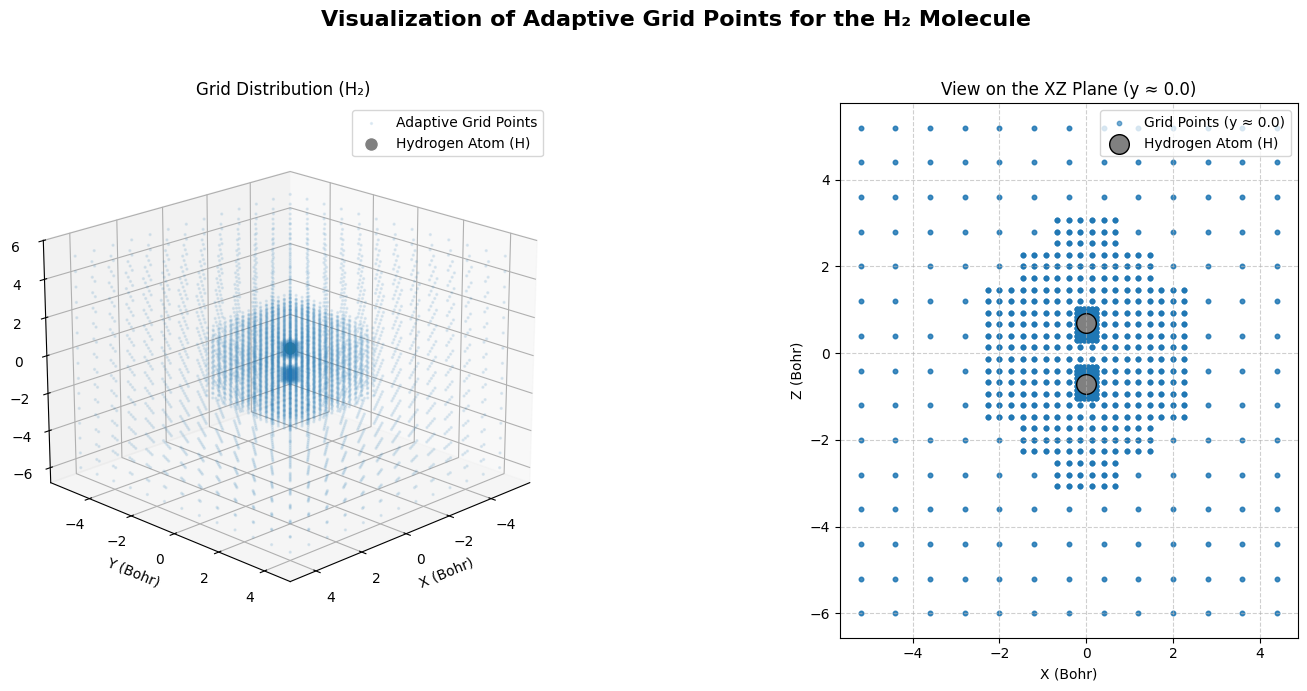

In [19]:
if 'final_grid_points' in locals() and 'h2_system' in locals() and h2_system:
    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    coords = h2_system.coords
    ax1.scatter(final_grid_points[:, 0], final_grid_points[:, 1], final_grid_points[:, 2], 
               s=2, alpha=0.1, label="Adaptive Grid Points")
    ax1.scatter(coords[:, 0], coords[:, 1], coords[:, 2], 
               s=100, c='gray', label='Hydrogen Atom (H)', edgecolors='w')

    ax1.set_title("Grid Distribution (H₂)")
    ax1.set_xlabel("X (Bohr)"); ax1.set_ylabel("Y (Bohr)"); ax1.set_zlabel("Z (Bohr)")
    ax1.legend()
    ax1.view_init(elev=20., azim=45)
    ax2 = fig.add_subplot(1, 2, 2)
    y_slice_center = 0.0
    slice_thickness = 0.5  
    slice_mask = np.abs(final_grid_points[:, 1] - y_slice_center) < slice_thickness
    slice_points = final_grid_points[slice_mask]
    if len(slice_points) > 0:
        ax2.scatter(slice_points[:, 0], slice_points[:, 2], 
                    s=10, alpha=0.6, label=f"Grid Points (y ≈ {y_slice_center})")
    ax2.scatter(coords[:, 0], coords[:, 2], 
                s=200, c='gray', label='Hydrogen Atom (H)', edgecolors='black')

    ax2.set_title(f"View on the XZ Plane (y ≈ {y_slice_center})")
    ax2.set_xlabel("X (Bohr)"); ax2.set_ylabel("Z (Bohr)")
    ax2.set_aspect('equal')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(loc='upper right')

    plt.suptitle("Visualization of Adaptive Grid Points for the H₂ Molecule", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
def create_promol_params(self, symbols, coords, deps):
        all_coeffs, all_exps, all_coords = [], [], []

        for i, symbol in enumerate(symbols):
            element_data = self.element_data[symbol.lower()]
            valid_mask = np.abs(element_data.coeffs_s) > 1e-12
            if np.any(valid_mask):
                all_coeffs.append(element_data.coeffs_s[valid_mask])
                all_exps.append(element_data.exps_s[valid_mask])
                all_coeffs[-1] *= np.sqrt(all_exps[-1] / np.pi) ** 3
                all_coords.append(coords[i])

        coeffs_padded, exps_padded = deps["_pad_coeffs_exps_with_zeros"](all_coeffs, all_exps)
        return deps["_PromolParams"](
            c_m=coeffs_padded, e_m=exps_padded, coords=np.array(all_coords), dim=3
        )